In [17]:
import numpy as np
import random

# Replay Buffer

Deque supports O(1) time complexity for adding/removing elements from both ends.

In [18]:
from collections import deque

deque([1,2,3,4,5,6], maxlen=3)

deque([4, 5, 6], maxlen=3)

In [19]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

# Gym Environment

In [20]:
import gym

In [21]:
env_id = "CartPole-v0"
env = gym.make(env_id)

/Users/manu13/anaconda3/envs/MLClass/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [22]:
env.observation_space, env.observation_space.shape, env.observation_space.shape[0]

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 (4,),
 4)

In [23]:
env.action_space, env.action_space.n

(Discrete(2), 2)

# Epsilon greedy exploration

In [24]:
import math

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 1000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

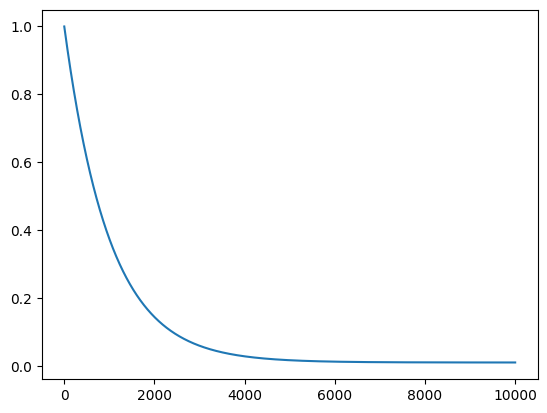

In [25]:
import matplotlib.pyplot as plt

plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Deep Q Network

In [27]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n))
    
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):

        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.tensor(state).to(torch.float32).unsqueeze(0)
            q_value = self.forward(state)
            action = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action


In [28]:
model = DQN(env.observation_space.shape[0], env.action_space.n)

optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(1000)

In [29]:
# Why we use torch.gather(): Take the q_values of the actions selected

q_values = torch.tensor([[1.0, 2.0, 3.0],
                         [4.0, 5.0, 6.0]])   # shape (2, 3)

actions = torch.tensor([[2],
                        [0]])                # shape (2, 1)

# Gather the Q-values at the chosen actions
chosen_q = torch.gather(q_values, dim=1, index=actions)
print(chosen_q)


tensor([[3.],
        [4.]])


In [30]:
def compute_td_loss(batch_size, gamma):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = torch.tensor(state).to(torch.float32)
    with torch.no_grad():
        next_state = torch.tensor(next_state).to(torch.float32)
    action = torch.tensor(action).to(torch.long)
    reward = torch.tensor(reward).to(torch.float32)
    done = torch.tensor(done).to(torch.float32)

    q_values = model(state)
    next_q_values = model(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_values = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_values * (1 - done)

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [33]:
from IPython.display import clear_output

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

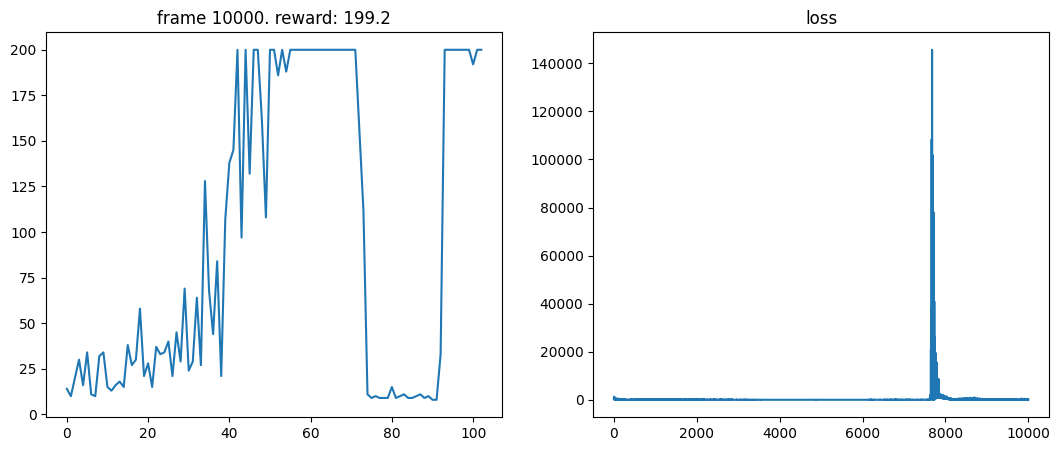

In [34]:
num_frames = 10000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

state, _ = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx=frame_idx)
    action = model.act(state, epsilon)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward

    if done:
        state, _ = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
    
    if len(replay_buffer) > batch_size:

        loss = compute_td_loss(batch_size=batch_size, gamma=gamma)
        losses.append(loss.item())
    
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)